Importing the libraries

In [50]:
# !pip install tensorflow==2.3.0
# !pip install keras==2.4.3
# !pip install pydot
import os
import random
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.keras import metrics

Loading the MNIST Dataset

In [17]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [166]:
# For vanilla CNN training, converting the labels to one hot encoded
# y_train_cat = tf.keras.utils.to_categorical(y_train)
# y_test_cat = tf.keras.utils.to_categorical(y_test)

In [167]:
# a vanilla CNN for MNIST

# inputs = Input(shape=(28,28,1))
# x = Conv2D(3, (2, 2), activation="relu")(inputs)
# # x = Conv2D(10, 3, activation = 'relu')(x)
# x = Flatten()(x)
# x = Dense(4, activation= 'relu')(x)
# outputs = Dense(10, activation= 'softmax')(x)
# model = Model(inputs=inputs, outputs=outputs)
# model.summary()
# model.compile(loss = tf.keras.losses.categorical_crossentropy,
#                 optimizer = tf.keras.optimizers.Adam(),
#                 metrics = ['accuracy'])
# model.fit(x_train, y_train_cat, epochs = 4)

Creating the Distance Layer for the Model

In [168]:
class DistanceLayer(tf.keras.layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

Defining the embedding model architecture

In [169]:
def create_siamese_twin():
    """
    creates and returns an embedding model to be used in the siamese architecture
    """
    # Define the tensors for the two input images
    input_twin = Input(IMAGE_SHAPE)
    #x = brand_model(input_twin)
    x = Conv2D(3, (2, 2), activation="relu")(input_twin)
    x = MaxPooling2D()(x)
    # x = Conv2D(512, (2, 2), activation="relu")(x)
    # x = MaxPooling2D()(x)
    # x = Conv2D(256, (1, 1), activation="relu")(x)
    x = Flatten()(x)
    outputs = Dense(128, name="final_dense", activation=None)(x)
    return Model(input_twin, outputs)

Putting the whole network together

In [20]:
def create_siamese_network():
    """
    creates and returns the final siamese architecture with the embedded model
    """
    middle_input = Input(IMAGE_SHAPE)
    left_input = Input(IMAGE_SHAPE)
    right_input = Input(IMAGE_SHAPE)
    twin = create_siamese_twin()
    
    distances = DistanceLayer()(twin(middle_input), twin(left_input), twin(right_input))
    
    model = Model(inputs=[middle_input, left_input, right_input], outputs=distances)
    return model

Defining the custom training loops

In [170]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")
        # self.accuracy = SiameseNetworkAccuracy

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        # self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}  # add accuracy

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

def accuracy(y_true, y_pred):
    """
    returns the keras binary accuracy
    """
    return binary_accuracy(y_true, 1 - y_pred)

In [171]:
# The image shape to be fed in the model
IMAGE_SHAPE = x_train.shape[1:]
print('IMAGE_SHAPE', IMAGE_SHAPE)

IMAGE_SHAPE (28, 28, 1)


In [172]:
NUM_POS = 4 # Number of positive examples to consider per class
NUM_NEG = 9 # Number of negative examples to consider per class

Triplet Generation

In [142]:
def shuffle_triplets(triplets):
    """
    returns the shuffled array of the triplets
    """
    triplets_len = list(range(len(triplets[0])))
    random.shuffle(triplets_len)
    triplets_shuffles = [triplets[0][triplets_len], triplets[1][triplets_len], triplets[2][triplets_len]]
    return triplets_shuffles

def create_triplets(label_set, validation_split = 0.7):
    """
    creates and splits all possible triplets for training and validation
    """
    triplet_images = []
    triplets_set = []
    left_images = []
    middle_images = []
    right_images = []
    set_labels = []

    for label in set(label_set):
        label_pos_ids = np.where(label_set == label)[0]
        label_neg_ids = np.where(label_set != label)[0]
        np.random.shuffle(label_pos_ids)
        np.random.shuffle(label_neg_ids)
        
        positive_examples = label_pos_ids[:NUM_POS]
        negative_examples = label_neg_ids[:NUM_NEG]
        triplet_labels = list(itertools.product(positive_examples, positive_examples, negative_examples))

        for trp in triplet_labels:
            left_images.append(x_train[trp[0]])
            middle_images.append(x_train[trp[1]])
            right_images.append(x_train[trp[2]])
            set_labels.append(1.0)
    
    triplets, labels = [np.array(left_images), np.array(middle_images), np.array(right_images)], np.array(set_labels)

    triplets = shuffle_triplets(triplets)
    
    split_point = int(NUM_POS * NUM_POS * NUM_NEG * len(set(label_set)) * 0.7)
    train_triplets, train_labels = [triplets[0][:split_point], triplets[1][:split_point], triplets[2][:split_point]], labels[:split_point]
    val_triplets, val_labels = [triplets[0][split_point:], triplets[1][split_point:], triplets[2][split_point:]], labels[split_point:]
    
    return (train_triplets, train_labels), (val_triplets, val_labels)  

In [173]:
# Storing the triplets
(train_triplets, train_labels), (val_triplets, val_labels)  = create_triplets(y_train)

In [175]:
# Checking the shapes for the triplets
print("Train Triplets Shape: {}, Train Labels Shape: {}".format(np.array(train_triplets).shape, train_labels.shape))
print("Val Triplets Shape: {}, Val Labels Shape: {}".format(np.array(val_triplets).shape, val_labels.shape))

Train Triplets Shape: (3, 1007, 28, 28, 1), Train Labels Shape: (1007,)
Val Triplets Shape: (3, 433, 28, 28, 1), Val Labels Shape: (433,)


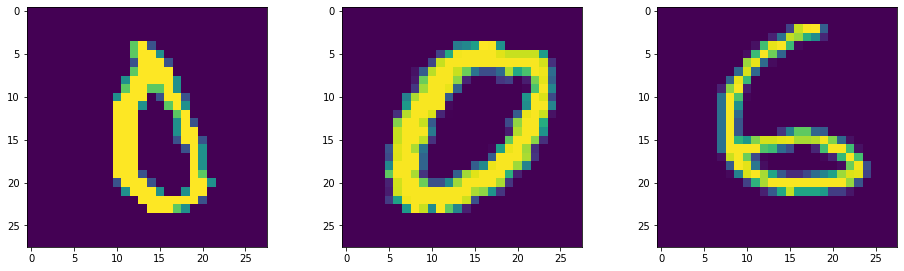

In [187]:
# plotting some triplets 
num = np.random.randint(0, len(train_labels))
plt.figure(figsize= (16,15))
plt.subplot(i+1,3,1)
plt.imshow(train_triplets[0][num])
plt.subplot(i+1,3,2)
plt.imshow(train_triplets[1][num])
plt.subplot(i+1,3,3)
plt.imshow(train_triplets[2][num])

Creating the model

Model: "functional_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_31 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
functional_29 (Functional)      (None, 128)          65039       input_29[0][0]                   
                                                                 input_30[0][0]       

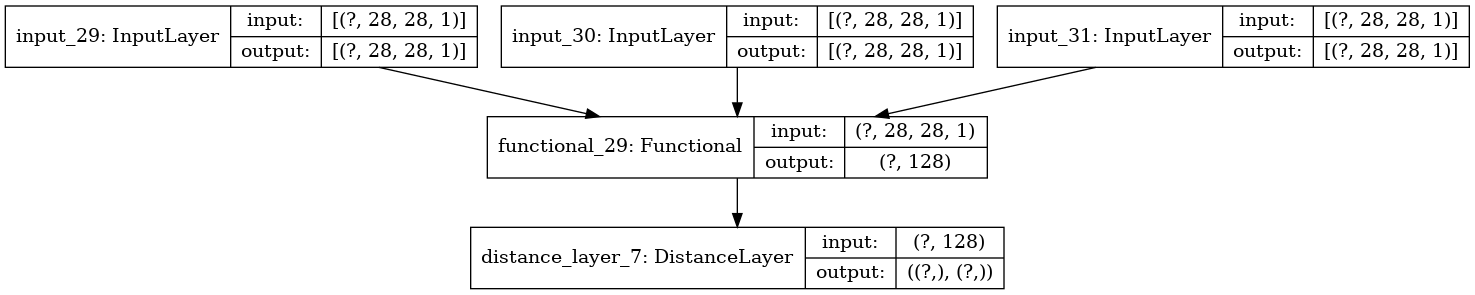

In [190]:
siamese_network = create_siamese_network()
siamese_network.summary()
tf.keras.utils.plot_model(siamese_network, show_shapes = True)

Compiling the Model

In [192]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), metrics=accuracy)

Training the model

In [193]:
siamese_model.fit((train_triplets, train_labels), validation_data= ((val_triplets, val_labels)), epochs = 10)

Epoch 1/10
32/32 [==============================] - 1s 26ms/step - loss: 0.4002 - val_loss: 0.2135
Epoch 2/10
32/32 [==============================] - 1s 24ms/step - loss: 0.2046 - val_loss: 0.0985
Epoch 3/10
32/32 [==============================] - 1s 25ms/step - loss: 0.1062 - val_loss: 0.0513
Epoch 4/10
32/32 [==============================] - 1s 25ms/step - loss: 0.0575 - val_loss: 0.0310
Epoch 5/10
32/32 [==============================] - 1s 25ms/step - loss: 0.0327 - val_loss: 0.0209
Epoch 6/10
32/32 [==============================] - 1s 24ms/step - loss: 0.0207 - val_loss: 0.0173
Epoch 7/10
32/32 [==============================] - 1s 26ms/step - loss: 0.0144 - val_loss: 0.0149
Epoch 8/10
32/32 [==============================] - 1s 27ms/step - loss: 0.0102 - val_loss: 0.0134
Epoch 9/10
32/32 [==============================] - 1s 26ms/step - loss: 0.0077 - val_loss: 0.0122
Epoch 10/10
32/32 [==============================] - 1s 26ms/step - loss: 0.0054 - val_loss: 0.0115


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f9d7a30a-760e-4df9-995d-bfc22963224f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>